In [ ]:
!pip install pandasql

In [1]:
# мы тут

In [ ]:
!gdown --id 1BSHIKQ7rFw5BpTq5nw1UZfjPK_7Mpnbi
!mv _sqlite3.cpython-37m-x86_64-linux-gnu.so /usr/lib/python3.7/lib-dynload/
#import os
#os.kill(os.getpid(), 9)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1BSHIKQ7rFw5BpTq5nw1UZfjPK_7Mpnbi
To: /content/_sqlite3.cpython-37m-x86_64-linux-gnu.so
100% 6.50M/6.50M [00:00<00:00, 26.9MB/s]


In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import plotly.express as px
from datetime import datetime as dt, timedelta
import pylab 
import scipy.stats as st
import statsmodels.stats.api as sms
import random
from tqdm.notebook import tqdm
from scipy.stats import norm, mannwhitneyu
from scipy.stats import ttest_ind
from tqdm.auto import tqdm
from scipy.stats import levene
import warnings
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
from scipy.stats import recipinvgauss
from pandasql import sqldf
import requests
from urllib.parse import urlencode
import sqlite3

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip3 install --upgrade pandas

In [ ]:
plt.style.use("dark_background")

# Проект: вариант 2
# Задание 1. A/B–тестирование
1.1 Условие
Одной из основных задач аналитика является корректное проведение экспериментов. Для этого применяется метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

Порядок проведения A/B–тестирования:
    . Определение общего критерия оценки (overall evaluation criterion, OEC).
    . Определение исследуемой мерики.
    . Формулирование нулевой и альтернативной гипотез.
    . Подготовка эксперимента:
        . Определение контрольной и экспериментальной групп.
        . Определение существующей baseline.
        . Минимальный эффект, который я хочу отследить.
        . Определение уровня статистической значимости.
        . Определение требуемой мощности.
        . Определение размеров выборок.
    . Проведение эксперимента.
        . Выбор метода статистического теста.
        . Проведение теста.
            . Проверка p-value.
            . Проверка мощности.
            . Проверка на корректность.
   . Анализ результатов эксперимента.
   . Вывод.
            
    

Исследование и подготовка данных.

In [ ]:
 groups_link = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg'
 groups_add_link = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'
 activ_studs_link = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg'
 checks_link = 'https://disk.yandex.ru/d/84hTmELphW2sqQ'

In [ ]:
# Загружаем файл.
def load_file(link_):
    public_key = link_
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=link_))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [ ]:
groups =  load_file(groups_link)
groups = pd.read_csv(groups, sep = ";") # файл с информацией о принадлежности пользователя 
                                                       # к контрольной или экспериментальной группе
                                                       # (А – контроль, B – целевая группа)

In [ ]:
group_add =  load_file(groups_add_link)
group_add = pd.read_csv(group_add) # дополнительный файл с пользователями,
                                                  # который вам прислали спустя 2 дня после передачи данных

In [ ]:
activ_studs =  load_file(activ_studs_link)
active_studs = pd.read_csv(activ_studs) # файл с информацией о пользователях, которые
                                                        # зашли на платформу в дни проведения эксперимента 

In [ ]:
checks =  load_file(checks_link)
checks = pd.read_csv(checks, sep = ";") # файл с информацией об оплатах пользователей в
                                                       # дни проведения эксперимента

In [ ]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [ ]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [ ]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [ ]:
groups.shape

(74484, 2)

In [ ]:
checks.shape

(541, 2)

In [ ]:
active_studs.shape

(8341, 1)

In [ ]:
groups['grp'].value_counts(normalize=True)

B    0.803032
A    0.196968
Name: grp, dtype: float64

In [ ]:
group_add['grp'].value_counts(normalize=True)

B    0.76087
A    0.23913
Name: grp, dtype: float64

In [ ]:
groups = groups.rename(columns={'grp': 'group'})

In [ ]:
group_add = group_add.rename(columns={'grp': 'group'})

In [ ]:
checks = checks.rename(columns={'student_id': 'id',
                                'rev': 'revenue'})

In [ ]:
active_studs['active'] = 1

In [ ]:
active_studs = active_studs.rename(columns={'student_id': 'id'})

In [ ]:
# Джойним данные в один датасет.
groups_all = groups.merge(group_add, how='outer', on=['id','group'])
groups_rev = groups_all.merge(checks, how='outer', on='id')
groups_rev_ac = groups_rev.merge(active_studs, how='outer', on='id')

In [ ]:
groups_rev_ac['active'] = groups_rev_ac['active'].fillna(0)

In [ ]:
group_a = groups_rev_ac.query('group == "A"')
group_b = groups_rev_ac.query('group == "B"')

In [ ]:
group_a_for_test = group_a.query('active > 0 & revenue > 0')
group_b_for_test = group_b.query('active > 0 & revenue > 0')

In [ ]:
data_revenue_a = group_a_for_test['revenue']
data_revenue_b = group_b_for_test['revenue']

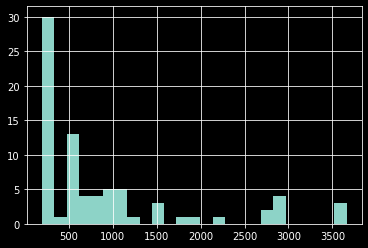

In [ ]:
data_revenue_a.hist(bins=25)

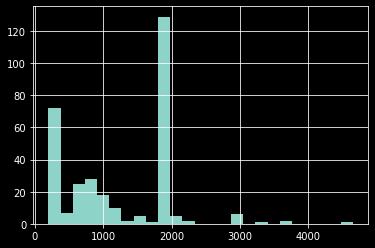

In [ ]:
data_revenue_b.hist(bins=25)

In [ ]:
data_revenue_b.value_counts(normalize=True)

1900.0000    0.296178
290.0000     0.143312
1900.0001    0.111465
199.0000     0.085987
840.0000     0.066879
990.0000     0.054140
690.0000     0.041401
1140.0000    0.028662
398.0000     0.019108
590.0000     0.019108
580.0000     0.015924
870.0000     0.015924
1530.0000    0.015924
2890.0000    0.009554
2099.0000    0.009554
3660.0000    0.006369
1980.0000    0.006369
2910.0000    0.006369
597.0000     0.003185
1339.0000    0.003185
489.0000     0.003185
1968.0000    0.003185
1050.0000    0.003185
2220.0000    0.003185
880.0000     0.003185
1388.0000    0.003185
1729.0000    0.003185
2190.0000    0.003185
4650.0000    0.003185
796.0000     0.003185
3040.0000    0.003185
3260.0000    0.003185
1160.0000    0.003185
Name: revenue, dtype: float64

In [ ]:
data_revenue_a.value_counts(normalize=True)

290.0     0.320513
580.0     0.076923
990.0     0.064103
199.0     0.064103
590.0     0.064103
690.0     0.051282
3660.0    0.038462
1530.0    0.038462
840.0     0.038462
2820.0    0.025641
1140.0    0.025641
2910.0    0.025641
489.0     0.025641
1160.0    0.025641
1039.0    0.012821
2890.0    0.012821
2220.0    0.012821
1180.0    0.012821
398.0     0.012821
1830.0    0.012821
1980.0    0.012821
2900.0    0.012821
870.0     0.012821
Name: revenue, dtype: float64

In [ ]:
# Проверяем все ли пользователи уникальные.
nunique_id = groups_rev_ac \
    .groupby('id', as_index=False) \
    .agg({'group':'nunique'}) \
    .sort_values('group', ascending=False)
nunique_id.shape[0] == groups_rev_ac.shape[0]

True

In [ ]:
# Пользователи, которые не заходили на платформу но совершили покупку.
no_active_and_pay =  groups_rev_ac.query('active == 0 & revenue > 0 ')
no_active_and_pay.head()

,id,group,revenue,active
39,3185,B,690.0,0.0
121,25973,B,690.0,0.0
125,26280,B,690.0,0.0
223,100645,B,630.0,0.0
254,102534,B,580.0,0.0


In [ ]:
# Выясняем, какие пользователи произвели оплату,
# не заходя на платформу (не из датасета group_add).
no_active_and_pay.merge(group_add, how='inner', on=['id', 'group'])

,id,group,revenue,active


In [ ]:
# Проверяем в какой из выборок были некорректные данные.
# Выясняем, что пользователи, которые произвели оплату не заходя на платформу - из датасета groups.
no_active_and_pay.merge(groups, how='inner', on=['id', 'group'])

,id,group,revenue,active
0,3185,B,690.0,0.0
1,25973,B,690.0,0.0
2,26280,B,690.0,0.0
3,100645,B,630.0,0.0
4,102534,B,580.0,0.0
...,...,...,...,...
144,5291900,B,199.0,0.0
145,5331842,B,290.0,0.0
146,5486319,B,199.0,0.0
147,5562806,B,398.0,0.0


In [ ]:
no_active_and_pay['group'].value_counts(normalize=True)

B    0.805369
A    0.194631
Name: group, dtype: float64

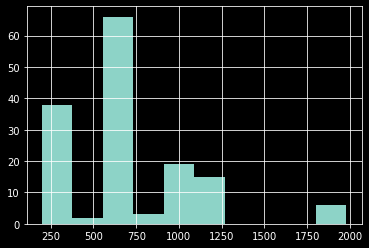

In [ ]:
no_active_and_pay['revenue'].hist()

In [ ]:
no_active_and_pay['revenue'].value_counts(normalize=True)

690.0000     0.409396
290.0000     0.161074
990.0000     0.127517
1140.0000    0.093960
199.0000     0.093960
580.0000     0.026846
1900.0000    0.026846
840.0000     0.020134
398.0000     0.013423
630.0000     0.006711
1980.0000    0.006711
1180.0000    0.006711
1900.0001    0.006711
Name: revenue, dtype: float64

In [ ]:
# Создаем сводную таблицу, в которой указываем количество пользователей,
# которые НЕ были активны и сделали покупку, их среднее, медиана и стандартное отклонение.
# Не выяснив причин возникновения данной ошибки мы решили не включать данных пользователей в эксперимент.
active_and_nopay_us_mean = no_active_and_pay \
    .groupby('group', as_index=False) \
    .agg({'revenue':['count','mean','median','std']})
active_and_nopay_us_mean

group revenue                               
          count        mean median         std
0     A      29  664.689655  690.0  371.793347
1     B     120  718.800001  690.0  381.133906

In [ ]:
# Для проведения статистических тестов мы решили учитывать только активных пользователей, 
# совершивших покупку.
active_and_pay =  groups_rev_ac.query('active > 0 & revenue > 0')
active_and_pay.head()

,id,group,revenue,active
1,1627,A,990.0000,1.0
220,100300,B,990.0000,1.0
320,108270,B,290.0000,1.0
3779,264473,B,1900.0001,1.0
4187,274352,B,690.0000,1.0


In [ ]:
# Все пользователи.
all_users =  groups_rev_ac.query('revenue > 0')
all_users_mean = all_users \
    .groupby('group', as_index=False) \
    .agg({'revenue':['count', 'mean','median','std']})
all_users_mean

group revenue                                
          count         mean median         std
0     A     107   860.710280  690.0  815.893445
1     B     434  1108.824893  935.0  741.834304

In [ ]:
# Для статиситческого теста используется 
# количество пользователей, которые были активны и сделали покупку, 
# их среднее, медиана и стандартное отклонение.
active_and_pay_us_mean = active_and_pay \
    .groupby('group', as_index=False) \
    .agg({'revenue':['count', 'mean','median','std']})
active_and_pay_us_mean

group revenue                                 
          count         mean  median         std
0     A      78   933.589744   585.0  919.932711
1     B     314  1257.878992  1140.0  790.864254

Проведение статистических тестов.

Т-тест Стьюдента.

In [ ]:
# Проверяем распределение выборочного среднего.
all_count = round(active_and_pay['revenue'].count())
all_mean = active_and_pay['revenue'].mean()
all_std = active_and_pay['revenue'].std()
sample_mean_distribution = \
    pd.Series([np.random.normal(all_mean, all_std, size=all_count).mean() for i in range(1000)])

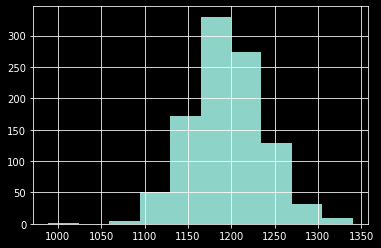

In [ ]:
sample_mean_distribution.hist()

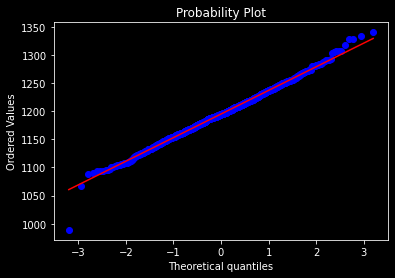

In [ ]:
st.probplot(sample_mean_distribution, dist="norm", plot=pylab)
pylab.show()

In [ ]:
# Проверка гомогенности дисперсий.
# Данный тест проверяет нулевую гипотезу о том, что входные выборки взяты
# из популяции с одинаковой дисперcией.
stat, p = levene(data_revenue_a, data_revenue_b, center='median')
p

0.08025675761347022

In [ ]:
# Проверяем мощность t-теста для наших размеров выборок.
baseline = data_revenue_a.mean()
mde = data_revenue_b.mean() - data_revenue_a.mean()
std_a = data_revenue_a.std()
std_b = data_revenue_b.std()
sample_size_a = len(data_revenue_a)
sample_size_b = len(data_revenue_b)
result = []
n = 10000
for _ in tqdm(range(n)):
  a = np.random.normal(baseline, std_a, size=sample_size_a)
  b = np.random.normal(baseline + mde, std_b, size=sample_size_b)
  _, pval = ttest_ind(a, b, equal_var=False)
  result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# Мощность нашего теста.
t = pd.Series(result)
(t < 0.05).mean()

0.8085

In [ ]:
# Проверяем пригодность теста. Генерируем выборки из одного распределения.
# p-value должно быть распределено равномерно.
baseline = data_revenue_a.mean()
std = data_revenue_a.std()
sample_size = len(data_revenue_a)
result = []
n = 10000
for _ in tqdm(range(n)):
  a = np.random.normal(baseline, std, size=sample_size)
  b = np.random.normal(baseline, std, size=sample_size)
  _, pval = ttest_ind(a,b,equal_var=False)
  result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
t = pd.Series(result)

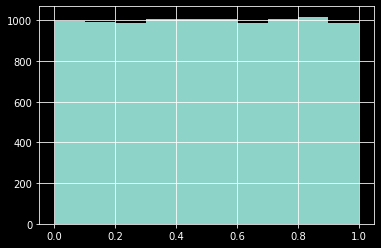

In [ ]:
# Распределение равномерное.
t.hist()

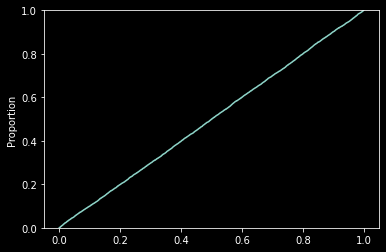

In [ ]:
# Это еще один способ проверки равномерности распределения.
# В случае искривления прямой распределение не равномерное.
sns.ecdfplot(t)

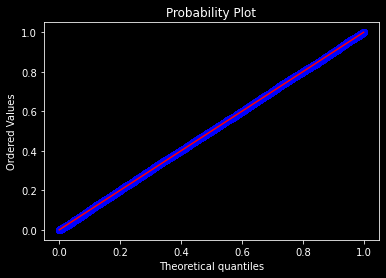

In [ ]:
# Также равномерность распределения удобно проверить с помощью QQ графика.
st.probplot(t, dist="uniform", plot=pylab)
pylab.show()

In [ ]:
# Все хорошо. Ошибка первого рода (False positive) не превышает 5%.
(t < 0.05).mean()

0.0521

In [ ]:
# Проверяем, какой размер выборок нам нужен для достижения нужной нам мощности еще одним способом.
mean_a = active_and_pay.query('group == "A"')['revenue'].mean()
mean_b = active_and_pay.query('group == "B"')['revenue'].mean()
es = (mean_b - mean_a)/ active_and_pay['revenue'].std()

In [ ]:
# Рекомендуемый размер выборки A для требуемых параметров.
sms.TTestIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=5/1)

61.59594762783004

In [ ]:
# Рекомендуемый размер выборки B для требуемых параметров.
sms.TTestIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1/5)

307.97973803008995

In [ ]:
# Проводим тест на наших данных.
n = 10000
result = []
for _ in tqdm(range(n)):
  control = data_revenue_a
  test = data_revenue_b
  _, pval = ttest_ind(control, test, equal_var=False)
  result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# Мощность
t = pd.Series(result)
(t < 0.05).mean()

1.0

In [ ]:
# p-value
t.mean()
# T-тест показал ошибку первого рода меньше 0.05 это говорит о том,
# что у нас между выборками есть статистически значимые различия.

0.0050697340127997485

Проверим наши данные на bootstrap.
    



In [ ]:
# Функция bootstrap
def bootstrap(control,test):
  n = 100 # Определяем количество эксперементов.
  result = [] # Создаем пустой список для результатов теста.
  base_diff = np.abs(control.mean() - test.mean()) # Абсольтная разница, которая получилась 
                                                   # в реальном эксперементе.
  merged = pd.Series(np.concatenate((control,test))) # Соединяем наши выборки в одну.

  for _ in range(n): # Создаем цикл, который будет складывать p-value в result.
    control = merged.sample(100, replace=True)
    test = merged.sample(100, replace=True)

    diff = np.abs(control.mean() - test.mean()) # Считаем абсолютную разницу средених в полученных выборках.

    result.append(diff >= base_diff) # Считаем количество значений равное или больше наблюдаемому
                                     # в проведенном эксперименте (прямо как в определении p-value:))
            
  return pd.Series(result).mean() # Взяв среднее по result мы получили наш p-value.

In [ ]:
# Проверка нашего теста. 
n = 100
result = []
for _ in tqdm(range(n)):
  control = data_revenue_a
  test = data_revenue_b
  pval = bootstrap(control,test)

  result.append(pval)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Мощьность нашего теста.
t = pd.Series(result)
(t < 0.05).mean()

1.0

In [ ]:
# p-value нашего теста.
t.mean()

0.005500000000000001

Проведем тест Манна-Уитни.

In [ ]:
n = 10000
result = []
for _ in tqdm(range(n)):
  control = data_revenue_a
  test = data_revenue_b
  _, pval = mannwhitneyu(control, test, alternative='two-sided')
  result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# Мощность нашего теста.
t = pd.Series(result)
(t < 0.05).mean()

1.0

In [ ]:
# p-value нашего теста.
t.mean()

0.0002511393831406302

Попробуем с помощью функции понять какое у нас распределение, а потом провести тест
Манн-Уитни.

In [ ]:
fit_distribution = groups_rev_ac.query('revenue > 0' )

  1 / 100: ksone
  2 / 100: kstwobign
  3 / 100: norm
  4 / 100: alpha
  5 / 100: anglit
  6 / 100: arcsine
  7 / 100: beta
  8 / 100: betaprime
  9 / 100: bradford
 10 / 100: burr
 11 / 100: burr12
 12 / 100: fisk
 13 / 100: cauchy
 14 / 100: chi
 15 / 100: chi2
 16 / 100: cosine
 17 / 100: dgamma
 18 / 100: dweibull
 19 / 100: expon
 20 / 100: exponnorm
 21 / 100: exponweib
 22 / 100: exponpow
 23 / 100: fatiguelife
 24 / 100: foldcauchy
 25 / 100: f
 26 / 100: foldnorm
 27 / 100: weibull_min
 28 / 100: weibull_max
 29 / 100: frechet_r
 30 / 100: frechet_l
 31 / 100: genlogistic
 32 / 100: genpareto
 33 / 100: genexpon
 34 / 100: genextreme
 35 / 100: gamma
 36 / 100: erlang
 37 / 100: gengamma
 38 / 100: genhalflogistic
 39 / 100: gompertz
 40 / 100: gumbel_r
 41 / 100: gumbel_l
 42 / 100: halfcauchy
 43 / 100: halflogistic
 44 / 100: halfnorm
 45 / 100: hypsecant
 46 / 100: gausshyper
 47 / 100: invgamma
 48 / 100: invgauss
 49 / 100: geninvgauss
 50 / 100: norminvgauss
 51 / 100: 

Text(0, 0.5, 'Frequency')

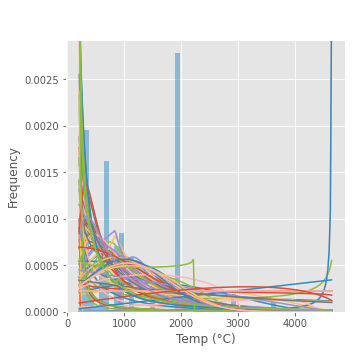

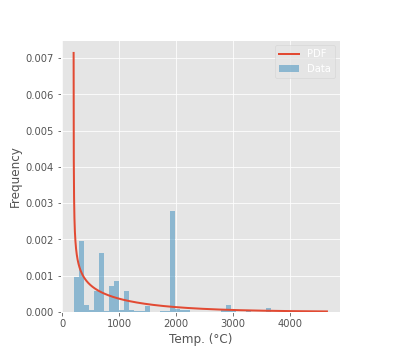

In [ ]:
matplotlib.rcParams['figure.figsize'] = (5.0, 5.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = fit_distribution['revenue']

# Plot for comparison
plt.figure(figsize=(5,5))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(5,5))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

In [ ]:
best_des = pd.DataFrame(best_distibutions).sort_values(2)
best_des

,0,1,2
0,<scipy.stats._continuous_distns.beta_gen objec...,"(0.6440161382107279, 14.509469739592314, 198.9...",2.383463e-04
1,<scipy.stats._continuous_distns.chi_gen object...,"(0.7101906160540404, 198.99999999999994, 1265....",2.389449e-04
2,<scipy.stats._continuous_distns.geninvgauss_ge...,"(0.7459260554362112, 7.317946544145188e-10, 19...",2.389913e-04
3,<scipy.stats._continuous_distns.exponpow_gen o...,"(0.7439551935109714, 198.99999999999994, 1471....",2.393753e-04
4,<scipy.stats._continuous_distns.pearson3_gen o...,"(2.3300018273214462, 954.5580860939862, 880.22...",2.393959e-04
...,...,...,...
87,<scipy.stats._continuous_distns.weibull_max_ge...,"(0.10451001257030429, 4650.000000000001, 1.756...",2.803493e-04
96,<scipy.stats._continuous_distns.frechet_l_gen ...,"(0.10451001257030429, 4650.000000000001, 1.756...",2.803493e-04
97,<scipy.stats._continuous_distns.vonmises_gen o...,"(0.2780276684331587, 1911.357493287016, 4.1807...",3.135157e+45
88,<scipy.stats._continuous_distns.powernorm_gen ...,"(2.626421387304855e-05, -190.55704359652202, 5...",NaN


In [ ]:
# Распределение которое нам подобрала функция recipinvgauss_gen.
best_des[0][0]

In [ ]:
# Параметры для создания распределения анологичного нашему.
a =  best_des[1][0][0]
b = best_des[1][0][1]
loc = best_des[1][0][2]

In [ ]:
# Создаем распределение анологичное нашему.
mean, var, skew, kurt = recipinvgauss.stats(a, b, loc, moments='mvsk')
mean

array(522.50793763)

In [ ]:
active_and_pay_us_mean

group revenue                                 
          count         mean  median         std
0     A      78   933.589744   585.0  919.932711
1     B     314  1257.878992  1140.0  790.864254

In [ ]:
# Корректируем средний под средний выборки A.
a, b, loc = 1813483.037979085, 198.99999999973454, 734.4029149415312
np.mean([np.mean(recipinvgauss.rvs(a, b, loc, 10000)) for i in range(1000)])

933.3348462269022

In [ ]:
# Корректируем средний под средний выборки B.
a1, b1, loc1 = 1813483.037979085, 198.99999999973454, 1058.4029149415312
np.mean([np.mean(recipinvgauss.rvs(a1, b1, loc1, 10000)) for i in range(1000)])

1257.019160954659

In [ ]:
# Проводим тест.
result = []
a1, b1, loc1 = 1813483.037979085, 198.99999999973454, 1058.4029149415312
a, b, loc = 1813483.037979085, 198.99999999973454, 734.4029149415312
n = 10000
for _ in tqdm(range(n)):
  control = recipinvgauss.rvs(a, b, loc, 78)
  test = recipinvgauss.rvs(a1, b1, loc1, 314)
  _, pval = mannwhitneyu(control, test, alternative='two-sided')
  result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
t = pd.Series(result)

In [ ]:
# Мощность теста очень низкая.
(t < 0.05).mean()

0.3439

In [ ]:
# p-value также высокий.
t.mean()

0.22631411977728666

In [ ]:
# Проверяем тест на адекватность.
result = []
a1, b1, loc1 = 1813483.037979085, 198.99999999973454, 1058.4029149415312
n = 10000
for _ in tqdm(range(n)):
  control = recipinvgauss.rvs(a1, b1, loc1, 78)
  test = recipinvgauss.rvs(a1, b1, loc1, 314)
  _, pval = mannwhitneyu(control, test, alternative='two-sided')
  result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
t = pd.Series(result)

In [ ]:
(t < 0.05).mean()

0.0498

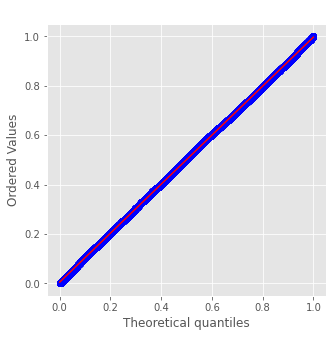

In [ ]:
st.probplot(t, dist="uniform", plot=pylab)
pylab.show()

В наших выборках слишком мало наблюдений. Увеличение количества наблюдений может положительно повлиять на подбор нужного распределения и мощности теста.

Анализ.
    1. Возникает вопрос: почему у нас целевая группа больше контрольное, ведь любое внесение изменений оплачивается заказчиком?
           Возможно у нас такая маленькая контрольная группа из-за ошибки. Стоит выяснить. Разница в              выборках 20/80 очень большая. Стоит обязательно провести А/А тест. 
    2. Почему у нас есть пользователи, которые не были активны, но совершили покупку?
           После выяснения причин возникновения данной ошибки мы можем принять решение включать ли                этих пользователей в наши статистические тесты.
    3. Из какого сегмента пришли пользователи на платформу с покупкой в 1900?
           Таких пользователей 30%, это существенная часть всех пользователей группы "B".
           В дальнейшем нужно выяснить что это за сегмент.
           Явно видно, что приток пользователей, приобретающей данную услугу увеличился. Стоит оценить            каковы перспективы извлечения выгоды и долгосрочный ли это эффект. Возможно в дальнейшем это            можно будет монитизировать.
    4. Почему у нас есть покупки с точностью до десятитысячных 1900.0001?
           Это 11% от всех пользователей в группе "B". Нужно выяснить почему так вышло.
           Данная погрешность не существенна. Если это не дубли, то можно ничего не предпринимать.

Вывод: 
  Возможные метрики - это средний чек и относительный CR активных пользователей. У нас был не большой выбор из-за малого количества факторов. Выбор метрик зависит от нашего EOC. Поскольку изменение касается способа оплаты, то мы можем передположить, что при прохождении воронки выбор способа оплаты снижал относительную конверсию в покупку. Это было причиной внедрения изменений. Также можно предположить, что внесенные изменения в способ оплаты увеличат средний чек у пользователей. Например, оплата покупок по частям увеличивает покупательскую способность клиента, следевательно средний чек вырастает. CR - такая метрика, которую нельзя расматривать без привязки к финансовым метрикам, поскольку это не всегда наилучший вариант оптимизации прибыли. Зачастую гораздо выгоднее привлечь более платёжеспособных пользователей, несмотря на то, что CR может уменьшиться. Выбираем исследуемую метрику - средний чек.
   После предварительного анализа мы выявили, что у нас есть измнения между контрольной и целевой группой. Они выражаются в росте среднего чека. В качестве нулевой гипотезы принимаем, что увеличения среднего чека случайны, и на самом деле никакой разницы нет. Альтернативная гипотеза говорит о том, что изменения среднего чека значимы и не случайны.
  В результате проведения статистических тестов мы выяснили, что все проведенные тесты показали нам уровень p-value значительно меньше 0,05. Принимаем альтернативную гипотезу.
  Перед запуском изменений на всех пользователей можно было бы провести более детальный анализ пользователей с покупкой в 1900, узнать, что это за сегмент пользователей. Откуда к нам пришли эти пользователи и насколько долгосрочным будет этот эффект от внесенного изменения. После этого можно проверить статистическими тестами относительный CR активных пользователей, является ли случайным его снижение. Затем можно соотнести снижение CR c повышением среднего чека. И уже после этого принимать решение о запуске изменений.

# Задание 2. SQL

2.1.1 Условие

Образовательные курсы состоят из различных уроков,
каждый из которых состоит из нескольких маленьких заданий.
Каждое такое маленькое задание называется "горошиной".
Назовём очень усердным учеником того пользователя, 
который хотя бы раз за текущий месяц правильно решил 20 горошин за час.

Необходимо написать оптимальный запрос, 
который даст информацию о количестве очень усердных студентов за март 2020 года.
NB! Под усердным студентом мы понимаем студента, 
который правильно решил 20 задач за текущий месяц.

SQL-выражение
Синтаксической разбор
Компоновка
Оптимизация запроса
Выполнение запроса
Результаты запроса

1. FROM
2. ON
3. JOIN
4. WHERE
5. GROUP BY
6. WITH CUBE или WITH ROLLUP
7. HAVING
8. SELECT
10. ORDER BY
11. TOP
12. SELECT (возврат результирующего датасета).


2. Понимание как храняться данные и выбираются(индексы, порциции)
3. Знания как физически выполняется JOIN(nested loops, hash and merge join)
4. Базовые принцыпы оптимизации.

In [ ]:
#con = sqlite3.connect('/content/drive/MyDrive/my_data/progect_1')

In [ ]:
#df.to_sql('progect_1',con,index=False,if_exists='replace')

In [ ]:
# Генерируем таблицу peas.
n = 1333
peas = pd.DataFrame({'st_id': np.random.poisson(400,size=n)})

start_date = pd.to_datetime('2020-03-01')
times_start = pd.date_range(start_date, periods=n, freq='30min')

peas['times_start'] = times_start

peas['timest'] = np.random.poisson(2,size=n)

peas['correct'] = pd.Series([True, True, True, True, True, True, True, True, True, False, False]) \
    .sample(len(peas),replace=True,random_state=42) \
    .values

peas['subject'] = pd.Series(['math', 'economics', 'sociology', 'philosophy', 'physics']) \
    .sample(len(peas),replace=True,random_state=42) \
    .values
peas.head()

,st_id,times_start,timest,correct,subject
0,396,2020-03-01 00:00:00,2,True,philosophy
1,419,2020-03-01 00:30:00,2,True,physics
2,398,2020-03-01 01:00:00,0,False,sociology
3,408,2020-03-01 01:30:00,2,True,physics
4,402,2020-03-01 02:00:00,3,True,physics


In [ ]:
# 1. Когорты по месяцам.
# 2. Ученик правильно решил.
# 3. Решил 20 горошин.
# 4. Какое количество таких учеников в когорте за март 2020.
# решение №1
q = """--EXPLAIN QUERY PLAN 
          WITH  peas_activ_march as (SELECT strftime('%Y-%m', times_start) as month,
                  count(st_id)         
          FROM peas
          WHERE correct = 1 and month ='2020-03'
          GROUP BY month, st_id
          HAVING count(st_id) >= 20)
      SELECT COUNT(*) AS active_students_March
      FROM peas_activ_march
     
        """

In [ ]:
sqldf(q)

,active_students_March
0,18


In [ ]:
# решение №2
q = """--EXPLAIN QUERY PLAN
       SELECT  COUNT(t.st_id) as active_students_March -- выводит результат количества учеников больше 20
       FROM (SELECT strftime('%Y-%m', times_start) as month, -- приводит время начала выполнения к году и мецяцу
                    SUM(correct) as correct, -- считает сумму правильных ответов
                    st_id -- выводит ид учеников
            FROM peas
            GROUP BY st_id, month, correct
            HAVING month = '2020-03'
            ) t
        WHERE t.correct >= 20 -- условие что правильных решений больше 20
        """

In [ ]:
sqldf(q)

,active_students_March
0,18


2.2 Оптимизация воронки
2.2.1 Условие
Образовательная платформа предлагает пройти студентам курсы по модели trial:
студент может решить бесплатно лишь 30 горошин в день.
Для неограниченого количества заданий в определенной дисциплине
студенту необходимо приобрести полный доступ. Команда провела эксперимент,
где был протестирован новый экран оплаты.

In [ ]:
# Генерируем таблицу studs.
n = 700
studs = pd.DataFrame({'st_id': np.arange(n)})

studs['test_grp'] = pd.Series(['A', 'A', 'A', 'B', 'B']) \
    .sample(len(studs),replace=True,random_state=42) \
    .values
studs.head()

,st_id,test_grp
0,0,B
1,1,B
2,2,A
3,3,B
4,4,B


In [ ]:
# Генерируем таблицу checks.
checks = pd.DataFrame({'st_id': peas['st_id'].sample(145).unique()})

start_date = pd.to_datetime('2020-03-01')
checks['sale_time'] = pd.date_range(start_date, periods=len(checks), freq='12H')

checks['subject'] = pd.Series(['math', 'economics', 'sociology', 'philosophy', 'physics']) \
    .sample(len(checks),replace=True,random_state=42) \
    .values

checks_price = pd.DataFrame({'math':[1000], 'economics':[750], 'sociology':[500], 'philosophy':[450], 'physics':[600]}) \
    .T \
    .reset_index() \

checks_price.columns = ['subject','subject_price']

checks = checks.merge(checks_price,how='left',on='subject')
checks.head()

,st_id,sale_time,subject,subject_price
0,392,2020-03-01 00:00:00,philosophy,450
1,378,2020-03-01 12:00:00,physics,600
2,399,2020-03-02 00:00:00,sociology,500
3,376,2020-03-02 12:00:00,physics,600
4,420,2020-03-03 00:00:00,physics,600


Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
ARPU=Конверсия*ARPPU
    Конверсия = Число пользователей / Число клиентов
    ARPPU = Доход / Число клиентов 
ARPAU - Сумма общего дохода за месяц / Общая ежемесячная база активных пользователей.
CR количество пользователей, которые выполнили какое-либо целевое действие / Общее число пользователей.
СR активного пользователя в покупку 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

In [ ]:
peas.head()

,st_id,times_start,timest,correct,subject
0,396,2020-03-01 00:00:00,2,True,philosophy
1,419,2020-03-01 00:30:00,2,True,physics
2,398,2020-03-01 01:00:00,0,False,sociology
3,408,2020-03-01 01:30:00,2,True,physics
4,402,2020-03-01 02:00:00,3,True,physics


In [ ]:
checks.head()

,st_id,sale_time,subject,subject_price
0,392,2020-03-01 00:00:00,philosophy,450
1,378,2020-03-01 12:00:00,physics,600
2,399,2020-03-02 00:00:00,sociology,500
3,376,2020-03-02 12:00:00,physics,600
4,420,2020-03-03 00:00:00,physics,600


In [ ]:
studs.head()

,st_id,test_grp
0,0,B
1,1,B
2,2,A
3,3,B
4,4,B


In [ ]:
q = """ WITH 
            -- Создаем временную таблицу с началом и окончанием времени эксперимента.
            checks_exp as (SELECT min(sale_time) as checks_start,
                                  max(sale_time) as checks_finish
                           FROM checks)
            ,
            -- Создаем временную таблицу peas в рамках проведения нашего эксперимента.            
            peas_unique as (SELECT st_id,
                                   1 as active, -- Добавляем столбец с активностью.
                                   subject as subject_active
                            FROM peas
                            WHERE times_start > (SELECT checks_start
                                                 FROM checks_exp)
                                  AND 
                                  times_start < (SELECT checks_finish
                                                 FROM checks_exp)
                            GROUP BY st_id)
            ,
            -- Джойним таблицы studs и peas_unique.
            studs_group_activ as (SELECT *
                                  FROM studs s
                                  LEFT JOIN peas_unique p ON s.st_id = p.st_id)
            ,
            -- Джойним таблицы studs_group_activ и checks.
            data_for_exp as (SELECT *
                             FROM studs_group_activ s
                             LEFT JOIN checks c ON s.st_id = c.st_id)
            ,
            -- Создаем таблицу с пользователями, которые были активны по математике.
            math_activ as (SELECT st_id,
                                  1 as math_activ
                           FROM data_for_exp
                           WHERE subject_active = "math")
            ,
            -- Создаем таблицу с пользователями, которые были активны по математике, и купили полный доступ.
            math_activ_pay as (SELECT st_id,
                                  1 as math_activ_pay
                           FROM data_for_exp
                           WHERE subject = "math"
                                 AND
                                 subject_active = "math")
            ,
            -- Джойним данные с активностью по математике к основной таблице.
            data_for_exp1 as (SELECT *
                             FROM data_for_exp s
                             LEFT JOIN math_activ c ON s.st_id = c.st_id)
            ,
            -- Джойним данные с активностью по математике и покупке полного доступа по математике.
            data_for_exp2 as (SELECT *
                             FROM data_for_exp1 s
                             LEFT JOIN math_activ_pay c ON s.st_id = c.st_id)
            ,
            -- Собираем только нужные столбцы для подсчета метрик в одну таблицу.
            result as (SELECT st_id,
                              test_grp,
                              active,
                              sale_time,
                              subject,
                              subject_price,
                              subject_active,
                              1 as user,
                              math_activ_pay,
                              math_activ
                       FROM data_for_exp2)
                       
      -- Подсчитываем нужные нам метрики.                     
      SELECT test_grp,
             SUM(subject_price) / SUM(active) as ARPAU,
             CAST(COUNT(st_id) / COUNT(subject_price) AS INT) *
             SUM(subject_price) / COUNT(subject_price) AS ARPU,
             CAST((CAST(COUNT(subject_price) AS Float64) / COUNT(st_id)) AS DECIMAL(5,2)) AS CR,
             CAST((CAST(COUNT(subject_price) AS Float64) / SUM(active)) AS DECIMAL(5,2)) AS CR_activ,
             CAST((CAST(SUM(math_activ_pay) AS Float64) /
             SUM(math_activ)) AS DECIMAL(5,2)) AS CR_activ_math_in_math_pay
             -- Данные для проверки вычислений.
             --SUM(user) as user_sum,
             --SUM(math_activ_pay) as math_activ_pay,
             --SUM(math_activ) as math_activ
             --COUNT(st_id) AS st_id_count ,
             --SUM(active) AS active_user_sum ,
             --COUNT(subject_price) AS subject_price_count
      FROM result
      GROUP BY test_grp
     """

In [ ]:
sqldf(q)

,test_grp,ARPAU,ARPU,CR,CR_activ,CR_activ_math_in_math_pay
0,A,385,6600,0.089109,0.642857,NaN
1,B,402,5117,0.114865,0.629630,0.1


# Задание 3. Python
3.1 Задача
Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [ ]:
def load_and_read_additional_users():
    # Загружаем файл.
    public_key = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    # Чтение файла.
    read = pd.read_csv(download_url)
    # Определяем в каком из столбцов хранится id, а в каком группа,
    # называем столбцы согласно их назначению.
    try:
        if int(read.loc[0][0]):
            read.columns = ['id', 'group']
    except ValueError:
            read.columns = ['group', 'id']
    # Выполняем соединение с основным датафреймом и подготовку для построения метрик. 
    groups_all = groups_rev_ac.merge(read, how='outer', on=['id','group'])     
    groups_all['active'] = groups_all['active'].fillna(0) 
    active_and_pay =  groups_rev_ac.query('active > 0 & revenue > 0')
    # Считаем основные метрики.
    active_and_pay_us_mean = active_and_pay \
        .groupby('group', as_index=False) \
        .agg({'revenue':['count','mean','median','std']})
    return active_and_pay_us_mean

In [ ]:
load_and_read_additional_users()

group revenue                                 
          count         mean  median         std
0     A      78   933.589744   585.0  919.932711
1     B     314  1257.878992  1140.0  790.864254

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [ ]:
def displot_metrics(data):
    group_a = data.query('group == "A"')
    group_b = data.query('group == "B"')
    group_a_for_test = group_a.query('active > 0 & revenue > 0')
    group_b_for_test = group_b.query('active > 0 & revenue > 0')
    data_revenue_a = group_a_for_test['revenue']
    data_revenue_b = group_b_for_test['revenue']
    # Строим дисплот.
    sns.displot(data=data,
                x='revenue',
                hue='group',
                legend=True,
                rug='True',
                kind='hist',
                element="step",
                bins=20,
                palette=sns.color_palette('bright')[:2], height=5, aspect=1.5)
    # Явно указываем нумерацию осей графика.
    plt.xticks(np.arange(0,5000,500))
    plt.yticks(np.arange(0,160,20))
    # Строим на графике наши метрики.
    plt.axvline(x=data_revenue_a.median(),
                color='blue',
                linestyle='--', 
                linewidth=0.9,
                label='{:5.0f} median group a'.format(np.median(data_revenue_a)))
    plt.axvline(x=data_revenue_b.median(),
                color='blue',
                linestyle='--', 
                linewidth=0.9,
                label='{:5.0f} median group b'.format(np.median(data_revenue_b)))
    plt.axvline(x=np.mean(data_revenue_a),
                color='orange',
                linestyle='-',
                linewidth=0.9,
                label='{:5.0f} mean group a'.format(np.mean(data_revenue_a)))
    plt.axvline(x=np.mean(data_revenue_b),
                color='orange',
                linestyle='-',
                linewidth=0.9,
                label='{:5.0f} mean group b'.format(np.mean(data_revenue_b)))
    plt.legend(title='metrics', loc='upper right')


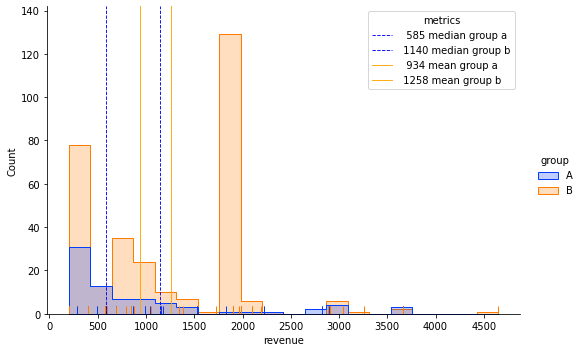

In [ ]:
displot_metrics(active_and_pay)